In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import linregress
from itertools import combinations

In [124]:
df = pd.read_csv(r'Historical Crypto Prices', index_col=0)
df.index = pd.to_datetime(df.index)
df

,Bitcoin,Binance,Cardano,Ethereum,Solana,XRP
Date,,,,,,
2020-07-13,9243.6,18.42,0.1244,239.73,1.279,0.1987
2020-07-14,9253.4,18.09,0.1324,240.50,1.115,0.1991
2020-07-15,9198.7,17.63,0.1306,238.62,1.383,0.1972
2020-07-21,9387.3,17.72,0.1231,245.53,1.004,0.1995
2020-07-22,9513.7,18.10,0.1238,263.28,1.046,0.2036
...,...,...,...,...,...,...
2024-12-07,99837.0,749.46,1.2105,3996.24,238.379,2.4936
2024-12-08,101115.8,741.84,1.1933,4002.91,237.097,2.6037
2024-12-09,97359.4,690.02,1.0068,3718.98,217.012,2.2191


In [129]:
tickers = list(df.columns)
weight = {ticker: 1/len(tickers) for ticker in tickers}

def calculate_investment_price(values, initial_value, base_value):
    total_value = sum(values.values())
    return (total_value / initial_value) * base_value

transaction_fee_rate = .0003
initial_investment = 1000000
base_value = 100

initial_shares = {
    ticker: ((initial_investment * weight[ticker]) / df[ticker].iloc[0]) for ticker in tickers
}

# double check initial values 
initial_values = {
    ticker: (initial_shares[ticker] * df[ticker].iloc[0]) for ticker in tickers
}
initial_total_value = sum(initial_values.values())

etf = [base_value]

for i in range(1, len(df)):
    # calculate current investment value for each asset 
    investment_per_stock = {
        ticker: (initial_shares[ticker] * df[ticker].iloc[i]) for ticker in tickers
    }

    total_investment = sum(investment_per_stock.values())

    # quarterly rebalance
    if i % 63 == 0:
        target_investment_per_stock = {
            ticker: (total_investment * weight[ticker]) for ticker in tickers
        }

        # calculate expected fees, i.e. the cost of rebalancing
        potential_fees = 0
        for ticker in tickers:
            target_shares = (target_investment_per_stock[ticker] / df[ticker].iloc[i])
            delta_shares = abs(target_shares - initial_shares[ticker])
            potential_fees += (delta_shares * df[ticker].iloc[i] * transaction_fee_rate)
        
        adjusted_total_investment = total_investment - potential_fees

        for ticker in tickers:
            target_investment_per_stock[ticker] = adjusted_total_investment * weight[ticker]
            initial_shares[ticker] = target_investment_per_stock[ticker] / df[ticker].iloc[i]
    
    # calculate the index price
    price = calculate_investment_price(investment_per_stock, initial_total_value, base_value)
    etf.append(price)

etf = pd.DataFrame(etf)
etf.rename(columns={0: 'Price'}, inplace=True)
etf.index = df.index

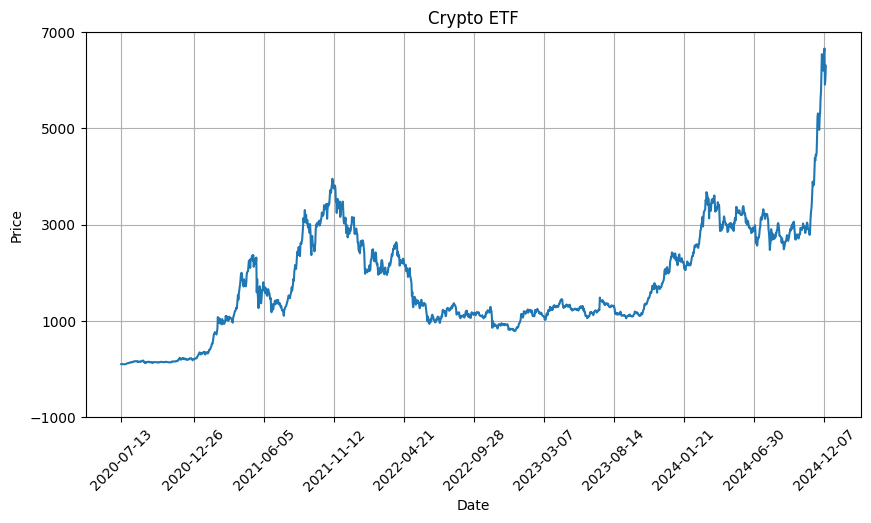

In [130]:
plt.figure(figsize=(10, 5))
plt.plot(etf["Price"])

x_ticks = etf.index[::len(etf) // 10]
plt.xticks(x_ticks, rotation=45)
y_ticks = plt.yticks()[0] 
plt.yticks(y_ticks[::2])

plt.xlabel("Date")
plt.ylabel("Price")
plt.title(f"Crypto ETF")
plt.grid(True)
plt.show()

In [131]:
# quick analysis of crypto etf performance

etf['Daily Return'] = etf['Price'].pct_change()
etf['Cumulative Return'] = (1 + etf["Daily Return"]).cumprod()
annualized_return = (etf['Cumulative Return'].iloc[-1] ** (252 / len(etf))) - 1

volatility = etf['Daily Return'].std() * (252 ** .5)

risk_free_rate = .02
sharpe_ratio = (annualized_return - risk_free_rate) / volatility

etf["Rolling Max"] = etf['Price'].cummax()
etf['Drawdown'] = (etf['Price'] - etf["Rolling Max"]) / etf['Rolling Max']
max_drawdown = etf['Drawdown'].min()

benchmark = yf.download("SPY", start="2020-07-13", end="2024-12-11")
benchmark['Daily Return'] = benchmark['Close'].pct_change()

cov_matrix = etf['Daily Return'].cov(benchmark['Daily Return'])
beta = cov_matrix / benchmark['Daily Return'].var()

alpha = annualized_return - (risk_free_rate + beta * (benchmark['Close'].pct_change().mean() * 252 - risk_free_rate))

[*********************100%***********************]  1 of 1 completed


In [140]:
summary = {
    "Annualized Return": annualized_return,
    "Volatility": volatility,
    "Sharpe Ratio": sharpe_ratio,
    "Max Drawdown": max_drawdown,
    "Alpha": alpha.iloc[0],
    "Beta": beta
}

summary_df = pd.DataFrame(summary, index=["Crypto ETF"])
summary_df



,Annualized Return,Volatility,Sharpe Ratio,Max Drawdown,Alpha,Beta
Crypto ETF,0.916497,0.652803,1.373304,-0.800194,0.647176,1.608164
